In [54]:
torch.cuda.empty_cache()

# Necessary Imports

In [55]:
import os
# Pandas and seaborn for plotting loss graphs
import pandas as pd
import seaborn as sns

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# Numpy
import numpy as np
# Pillow
from PIL import Image, ImageOps
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torchvision
from torch.optim import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
dataset_paths = {'train_normal': './dataset/train/normal/',\
                 'train_infected_covid': './dataset/train/infected/covid/',\
                 'train_infected_non_covid': './dataset/train/infected/non-covid/',\
                 'val_normal': './dataset/val/normal/',\
                 'val_infected_covid': './dataset/val/infected/covid/',\
                 'val_infected_non_covid': './dataset/val/infected/non-covid/',\
                 'test_normal': './dataset/test/normal/',\
                 'test_infected_covid': './dataset/test/infected/covid/',\
                 'test_infected_non_covid': './dataset/test/infected/non-covid/'}
print(dataset_paths)

{'train_normal': './dataset/train/normal/', 'train_infected_covid': './dataset/train/infected/covid/', 'train_infected_non_covid': './dataset/train/infected/non-covid/', 'val_normal': './dataset/val/normal/', 'val_infected_covid': './dataset/val/infected/covid/', 'val_infected_non_covid': './dataset/val/infected/non-covid/', 'test_normal': './dataset/test/normal/', 'test_infected_covid': './dataset/test/infected/covid/', 'test_infected_non_covid': './dataset/test/infected/non-covid/'}


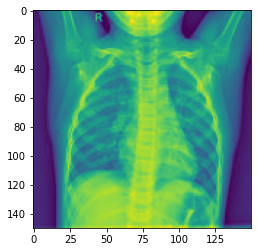

In [57]:
path_to_file = './dataset/train/normal/0.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()

In [58]:
print(im.shape)

(150, 150)


# Train Dataset

In [59]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles the important parameters in attrributes
        
        """
        
        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
        
        # This dataset consists only of training images
        self.groups = 'train'
        
        self.dataset_numbers = {'train_normal':1341,\
                                'train_infected_non_covid': 2530,\
                                'train_infected_covid':1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_non_covid': './dataset/train/infected/non-covid/'}
    
    def describe(self):
        """
        Descripter function
        Will print details about the dataset when called
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_non_covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_non_covid'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = "infected_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label


# Test Dataset

In [60]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles the important parameters in attrributes
        
        """
        
        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
        
        # This dataset consists only of testing images
        self.groups = 'test'
        
        self.dataset_numbers = {'test_normal':234,\
                                'test_infected_non_covid': 242,\
                                'test_infected_covid':138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                 'test_infected_covid': './dataset/test/infected/covid/',\
                 'test_infected_non_covid': './dataset/test/infected/non-covid/'}
    
    def describe(self):
        """
        Descripter function
        Will print details about the dataset when called
        """
        
        # Generate description
        msg = "This is the testing dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_non_covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_non_covid'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = "infected_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label


# Validation Dataset

In [61]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles the important parameters in attrributes
        
        """
        
        #  All images are of size 150x150
        self.img_size = (150, 150)
        
        # Instead of two classes like the mock data we have three classes here to consider(normal, infected-covid, infected-non-covoid)
        self.classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
        
        # This dataset consists only of validation images
        self.groups = 'val'
        
        self.dataset_numbers = {'val_normal':8,\
                                'val_infected_non_covid': 8,\
                                'val_infected_covid':8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                 'val_infected_covid': './dataset/val/infected/covid/',\
                 'val_infected_non_covid': './dataset/val/infected/non-covid/'}
    
    def describe(self):
        """
        Descripter function
        Will print details about the dataset when called
        """
        
        # Generate description
        msg = "This is the validation dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_non_covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
        
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_non_covid'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = "infected_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 0, 1])
            
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [62]:
#Create instances of Dataset for future use

ld_train = Lung_Train_Dataset()
ld_test = Lung_Test_Dataset()
ld_val = Lung_Val_Dataset()

im,cls = ld_train[63]
print(cls)
print(im)

tensor([1., 0., 0.])
tensor([[[0.1529, 0.1882, 0.2275,  ..., 0.0941, 0.0314, 0.0706],
         [0.1373, 0.1765, 0.2157,  ..., 0.0863, 0.0275, 0.0706],
         [0.1137, 0.1608, 0.2078,  ..., 0.0745, 0.0235, 0.0706],
         ...,
         [0.0980, 0.0980, 0.0941,  ..., 0.0784, 0.0824, 0.0824],
         [0.0980, 0.0980, 0.0980,  ..., 0.0824, 0.0824, 0.0863],
         [0.1020, 0.0980, 0.0980,  ..., 0.0824, 0.0863, 0.0863]]])


In [63]:
len(ld_train)

5216

# Exploring our Dataset
Shows the distribution of the difference classes among the 3 groups of dataset we have

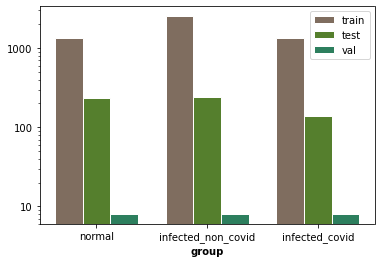

In [64]:
ld_train_counts = list(ld_train.dataset_numbers.values())
ld_test_counts = list(ld_test.dataset_numbers.values())
ld_val_counts = list(ld_val.dataset_numbers.values())

# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = ld_train_counts
bars2 = ld_test_counts
bars3 = ld_val_counts
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='test')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='val')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['normal', 'infected_non_covid', 'infected_covid'])
 
# Create legend & Show graphic
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.legend()
plt.show()

## (C) Why do we need to normalize images? 

In our custom Dataset class, we return our input image as a normalized array. In particular we converted the image to a numpy array and normalize the pixel values by dividing it by 255 before returning the image from the open_img() function. The reason why we do this is because when training a Deep Neural Network with images, the computation of high numeric values may become complex, as pixel values range from 0 to 256, apart from 0 the range is 255, so we divide it by that value and now our computation works with values ranging from 0 to 1, making it easier and thus faster.

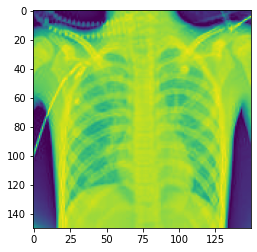

In [65]:
ld_train.show_img('train','infected_non_covid',296)

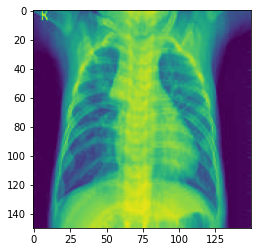

In [66]:
ld_train.show_img('train','infected_non_covid', 293)

# Creating Dataloaders

In [67]:
#Initializing our dataloaders from different datasets
train_loader = DataLoader(ld_train, batch_size = 32, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = 32, shuffle = True)

#We set the shuffle to false for val_loader because we need to use it to visualize our results later for plotting
val_loader = DataLoader(ld_val, batch_size = 24, shuffle = True)

In [68]:
print(len(train_loader))

163


# Creating our own Neural Net for classification

In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = self.conv_block(c_in=1, c_out=256, dropout=0.3, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.3, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.3, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=20, stride=1, padding=0)        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_layers = Sequential(
            Linear(648,3)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)        
        x = self.block2(x)        
        x = self.block3(x)
        x = self.maxpool(x)        
        x = self.lastcnn(x)  
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)      
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )        
        return seq_block

# Defining functions used for Training

In [70]:
def multi_acc(predicted_output, ground_truth_label):
    predicted_output = torch.log_softmax(predicted_output, dim = 1)
    _, predicted_output = torch.max(predicted_output, dim = 1) 
    correct_pred = (predicted_output == ground_truth_label).float()
    acc = correct_pred.sum() / len(ground_truth_label)
    acc = torch.round(acc* 100) 
    return acc

def load_checkpoint(PATH):
    if os.path.isfile(PATH):
        print('Model checkpoint found, loading model...')
        checkpoint = torch.load(PATH)        
        return checkpoint
    else:
        print('No checkpoint found')
        return 

def save_checkpoint(epoch, PATH, loss_stats, accuracy_stats):
    # SAVE MODEL CHECKPOINT
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_stats': loss_stats,
        'accuracy_stats': accuracy_stats
    }, PATH)

# Training our model

In [71]:
# We first initialize a brand new model from our architecture
device = "cpu"
model = Net()
optimizer = SGD(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

# Check if Cuda is available
if torch.cuda.is_available():
    device = "cuda"
    model = model.to(device)
    criterion = criterion.to(device)
    
# Define the dictionary used to store accuracy and loss values
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

# define start and end epoch
start_epoch = 0
num_epochs = 50

# attempts to load a checkpoint, if it doesn't exist it will return null
checkpoint = load_checkpoint('multi_class_model.pt')

# if the checkpoint exist then we load in all the values saved
if checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss_stats = checkpoint['loss_stats']
        accuracy_stats = checkpoint['accuracy_stats']
        
# Check if resuming training or training from scratch depending if model is found or not
if start_epoch != 0:
    print('Resuming Training from epoch: {}'.format(start_epoch+1))
else:
    print('Beginning Training from scratch...')
        
for e in range(start_epoch+1, num_epochs+1):    
    print('-' * 10)
    print('Epoch {}/{}'.format(e, num_epochs))
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for batch_idx, (inputs,labels) in enumerate(train_loader):
        train_inputs = inputs.to(device)
        train_labels = labels.to(device)
        optimizer.zero_grad()
        train_outputs = model(train_inputs).squeeze()
        
        train_loss = criterion(train_outputs, torch.max(train_labels,1)[1])
        train_acc = multi_acc(train_outputs, torch.max(train_labels,1)[1])
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for batch_idx, (inputs,labels) in enumerate(test_loader):
            val_inputs = inputs.to(device)
            val_labels = labels.to(device)
            val_outputs = model(val_inputs).squeeze()
            val_loss = criterion(val_outputs, torch.max(val_labels,1)[1])
            val_acc = multi_acc(val_outputs, torch.max(val_labels,1)[1])
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(test_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(test_loader))
    print(f'Epoch {e}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(test_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(test_loader):.3f}')
    
    save_checkpoint(e, 'multi_class_model.pt', loss_stats, accuracy_stats)

print("Training Completed. Saving final multiclass model...")
torch.save(model, "final_multiclass_model.pt")

No checkpoint found
Beginning Training from scratch...
----------
Epoch 1/50
Epoch 1: | Train Loss: 1.01145 | Val Loss: 0.94832 | Train Acc: 51.564| Val Acc: 57.500
----------
Epoch 2/50
Epoch 2: | Train Loss: 0.89374 | Val Loss: 0.87237 | Train Acc: 63.153| Val Acc: 63.000
----------
Epoch 3/50
Epoch 3: | Train Loss: 0.80519 | Val Loss: 0.79931 | Train Acc: 65.914| Val Acc: 66.300
----------
Epoch 4/50
Epoch 4: | Train Loss: 0.75446 | Val Loss: 0.76869 | Train Acc: 68.098| Val Acc: 68.100
----------
Epoch 5/50
Epoch 5: | Train Loss: 0.71559 | Val Loss: 0.75414 | Train Acc: 68.939| Val Acc: 70.550
----------
Epoch 6/50
Epoch 6: | Train Loss: 0.68278 | Val Loss: 0.71567 | Train Acc: 71.454| Val Acc: 74.150
----------
Epoch 7/50
Epoch 7: | Train Loss: 0.66448 | Val Loss: 0.73559 | Train Acc: 71.791| Val Acc: 70.950
----------
Epoch 8/50
Epoch 8: | Train Loss: 0.64917 | Val Loss: 0.72082 | Train Acc: 72.153| Val Acc: 71.350
----------
Epoch 9/50
Epoch 9: | Train Loss: 0.63618 | Val Loss: 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Visualizing our Loss and Accuracy

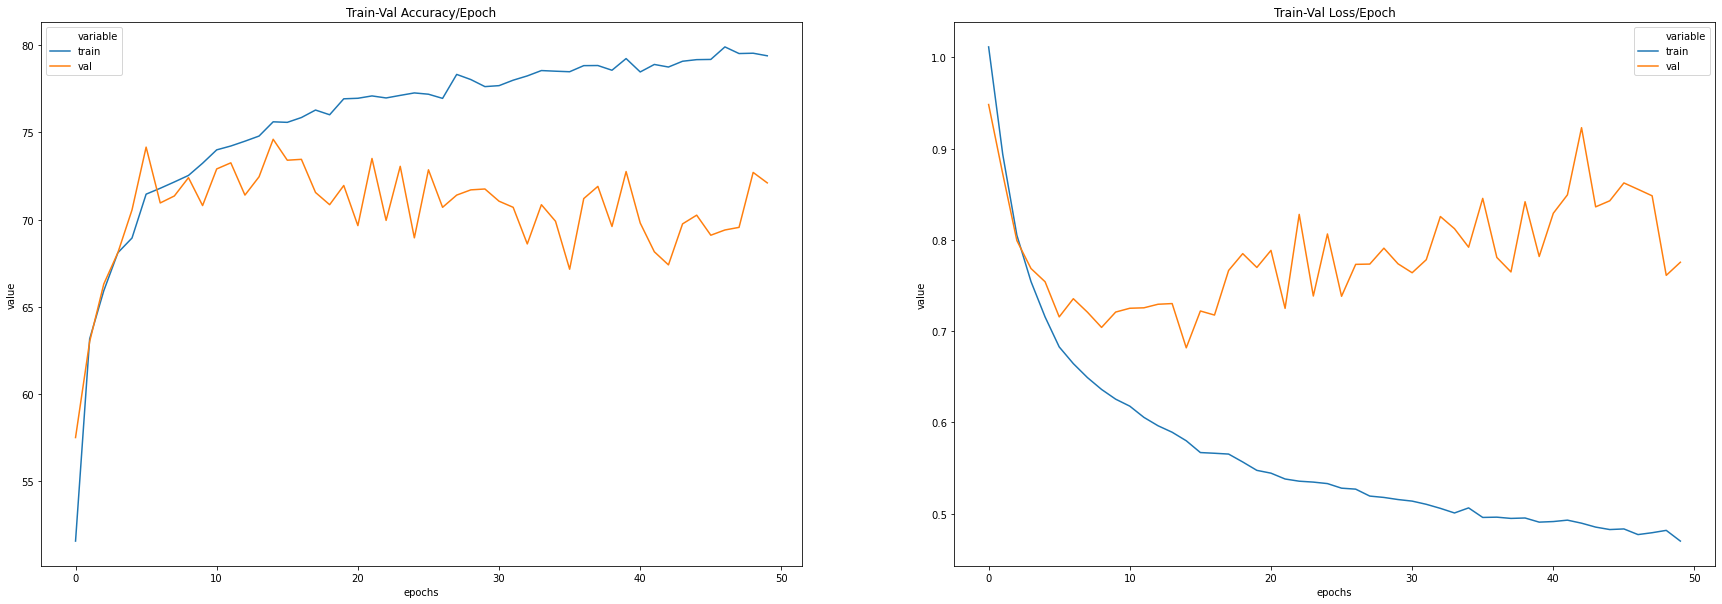

In [75]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


# Saving the figure
fig.savefig("train-val-loss-accuracy-plot-MULTICLASS.png")

# Running our model on Test Dataset (optional: loading trained model)
Confusion Matrix  and Classification Report

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      0.50      0.50         8
           2       0.50      0.75      0.60         8

    accuracy                           0.58        24
   macro avg       0.67      0.58      0.59        24
weighted avg       0.67      0.58      0.59        24



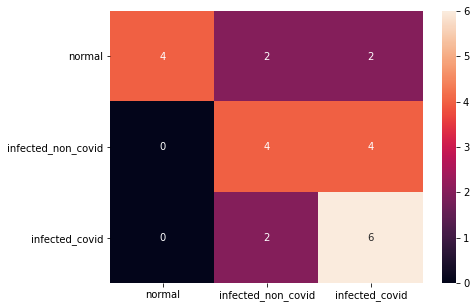

In [76]:
from itertools import chain 

# Loading the pre-trained saved model from path. We can skip this if just running the whole notebook as a whole
trained_model = torch.load('final_multiclass_model.pt')

test_outputs_list = []
test_labels_list = []
with torch.no_grad():
#     for x_batch, y_batch in tqdm(test_loader):
    for batch_idx, (inputs,labels) in enumerate(val_loader):
        test_inputs, test_labels = inputs.to(device), labels.to(device)
#         torch.max(val_labels,1)[1]
        test_outputs = trained_model(test_inputs)
        test_outputs_for_plot = model(val_inputs).squeeze()
        _, test_outputs = torch.max(test_outputs, dim = 1)
        test_outputs_list.append(test_outputs.cpu().numpy())
        test_labels_list.append(torch.max(test_labels,1)[1].cpu().numpy())


# Flattening the predicted outputs and true lables
test_outputs_list = list(chain.from_iterable(test_outputs_list))
test_labels_list = list(chain.from_iterable(test_labels_list))

report = classification_report(test_labels_list, test_outputs_list, output_dict=True)

print(classification_report(test_labels_list, test_outputs_list))

#Creating a data-frame from confusion matrix and plot it as a heaet-map using seaborn library
classes = {0:'normal', 1:'infected_non_covid', 2:'infected_covid'}
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_labels_list, test_outputs_list)).rename(columns=classes, index=classes)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

# Visualizing our predictions vs ground truths

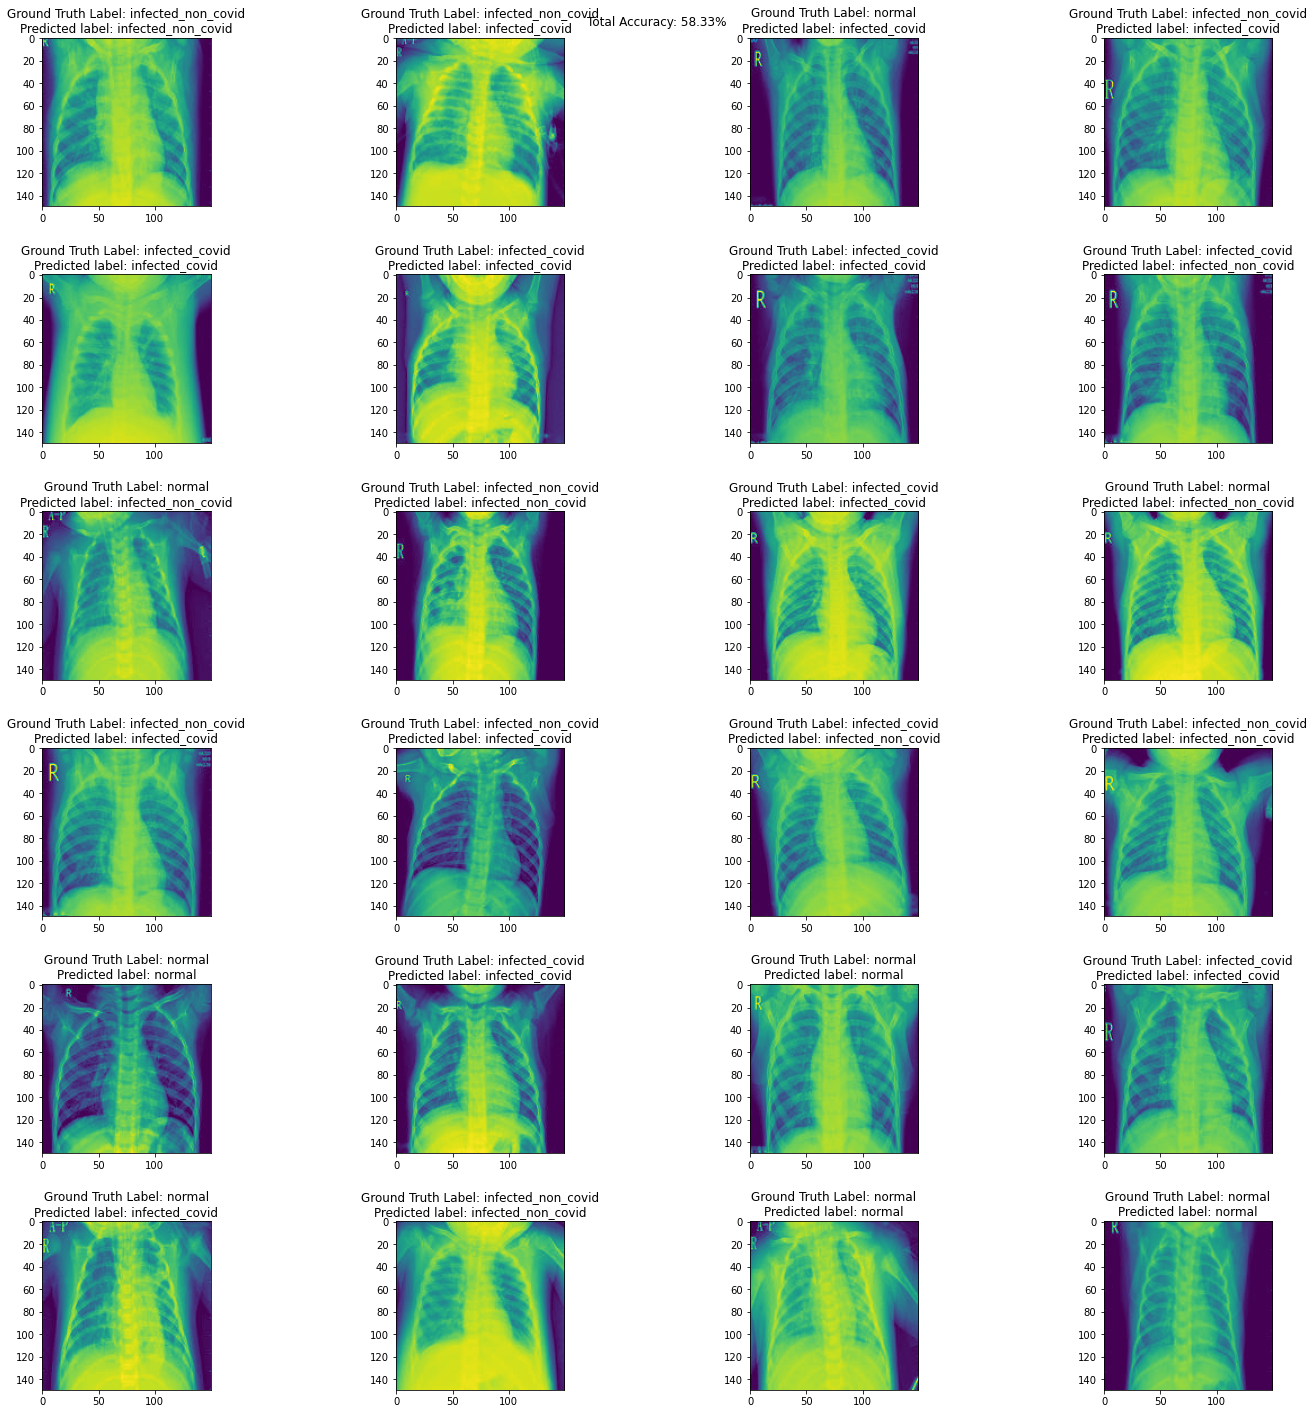

In [77]:
import numpy as np
import matplotlib.pyplot as plt

w = 50
h = 50
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 6

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for inputs,labels in (val_loader):
    images, labels = inputs, labels


for i in range(columns*rows):
    image_data = images[i]
    img = image_data.reshape(150,150).numpy()
    
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Ground Truth Label: " + ld_val.classes.get(test_labels_list[i]) # set ground truth label
                    +'\n'+ 'Predicted label: '+ ld_val.classes.get(test_outputs_list[i]) ) # set predicted label

    plt.imshow(img, alpha=1)

# do extra plots on selected axes/subplots
# note: index starts with 0
ax[2].plot(xs, 3*ys)
ax[19].plot(ys**2, xs)
title = "Total Accuracy: " + "{:.2f}".format(report["accuracy"]*100) +"%"
fig.suptitle(title)
plt.tight_layout(pad=2)
plt.show()  # finally, render the plot